# 🏴‍☠️ Pain Pirate Analysis - Pipeline Completa TensorFlow

Pipeline end-to-end con **tutte le 7 ADVICE del professore integrate nel codice**.

## Dataset
- **pirate_pain_train.csv**: 105,760 righe = 661 samples × 160 timesteps
- **pirate_pain_train_labels.csv**: 661 labels (no_pain, low_pain, high_pain)
- **Features**: 38 (4 pain_survey + 3 categorical + 31 joints)
- **Classe dominante**: no_pain (511) - dataset **sbilanciato**!

## ADVICE Integrate
1. ✅ **11/11 - Autocorrelazione**: Window size basata sui dati
2. ✅ **12/11 - Time Features**: Encoding ciclico temporale
3. ✅ **13/11 - Conv1D+LSTM**: Architettura ibrida
4. ✅ **10/11 - Gradient Clipping**: Stabilizza training
5. ✅ **09/11 - Label Smoothing**: Loss con smoothing
6. ✅ **08/11 - Class Weighting**: Gestisce sbilanciamento
7. ✅ **07/11 - Embeddings**: Features categoriche


In [2]:
# Core libraries
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# TensorFlow/Keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# Stats and ML
from statsmodels.tsa.stattools import acf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from sklearn.utils.class_weight import compute_class_weight

# Set seeds
SEED = 42
os.environ['PYTHONHASHSEED'] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')

print(f'TensorFlow: {tf.__version__}')
print(f'GPU: {tf.config.list_physical_devices("GPU")}')
print('✅ Environment ready!')

TensorFlow: 2.16.2
GPU: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
✅ Environment ready!


## 1. Caricamento Dati

In [3]:
# Load dataset
X_train = pd.read_csv('pirate_pain_train.csv')
y_train = pd.read_csv('pirate_pain_train_labels.csv')

print('📊 Dataset Shape:')
print(f'  Features: {X_train.shape}')
print(f'  Labels: {y_train.shape}')
print(f'  Samples: {X_train["sample_index"].nunique()}')
print(f'  Timesteps/sample: {X_train.groupby("sample_index").size().iloc[0]}')

# Feature groups
pain_survey_cols = [c for c in X_train.columns if 'pain_survey' in c]
categorical_cols = ['n_legs', 'n_hands', 'n_eyes']
joint_cols = [c for c in X_train.columns if 'joint_' in c]

print(f'\n📋 Features: {len(pain_survey_cols)} pain_survey + {len(categorical_cols)} categorical + {len(joint_cols)} joints')

# ADVICE 08/11: Check class imbalance
print(f'\n🏷️ Labels (IMBALANCED - need class weighting):')
for label, count in y_train['label'].value_counts().items():
    print(f'  {label}: {count} ({100*count/len(y_train):.1f}%)')

📊 Dataset Shape:
  Features: (105760, 40)
  Labels: (661, 2)
  Samples: 661
  Timesteps/sample: 160

📋 Features: 4 pain_survey + 3 categorical + 31 joints

🏷️ Labels (IMBALANCED - need class weighting):
  no_pain: 511 (77.3%)
  low_pain: 94 (14.2%)
  high_pain: 56 (8.5%)


## 2. ADVICE 11/11: Determinare WINDOW_SIZE

*"Its own echo, the series sings."*

Usiamo autocorrelazione per scegliere window size basata sui dati.

In [4]:
# ADVICE 11/11: Analyze autocorrelation to determine optimal window
print('🔍 Analyzing autocorrelation...')
samples_analyze = X_train['sample_index'].unique()[:10]
key_features = joint_cols[:6]

optimal_lags = {}
for feature in key_features:
    sample_lags = []
    for sid in samples_analyze:
        data = X_train[X_train['sample_index']==sid][feature].values
        if len(data) >= 50:
            max_lags = min(len(data)//2-1, 80)
            acf_vals = acf(data, nlags=max_lags)
            sig_bound = 1.96/np.sqrt(len(data))
            for lag in range(1, len(acf_vals)):
                if abs(acf_vals[lag]) < sig_bound:
                    sample_lags.append(lag)
                    break
            else:
                sample_lags.append(max_lags)
    if sample_lags:
        optimal_lags[feature] = int(np.median(sample_lags))

if optimal_lags:
    suggested = int(np.median(list(optimal_lags.values())))
    WINDOW_SIZE = max(min(suggested, 100), 40)
else:
    WINDOW_SIZE = 60

WINDOW_STRIDE = WINDOW_SIZE // 2

print(f'✅ WINDOW_SIZE from autocorrelation: {WINDOW_SIZE}')
print(f'   STRIDE: {WINDOW_STRIDE}')
print(f'💡 ADVICE 11/11: Data-driven window size!')

🔍 Analyzing autocorrelation...
✅ WINDOW_SIZE from autocorrelation: 40
   STRIDE: 20
💡 ADVICE 11/11: Data-driven window size!


## 3. Preprocessing con ADVICE 07/11 e 12/11

**ADVICE 07/11**: Map categorical per embeddings  
**ADVICE 12/11**: Aggiungi time features ciclici

In [5]:
# ADVICE 07/11: Map categorical features
cat_map = {
    'n_legs': {'two': 0, 'one+peg_leg': 1},
    'n_hands': {'two': 0, 'one+hook_hand': 1},
    'n_eyes': {'two': 0, 'one+eye_patch': 1}
}

X_proc = X_train.copy()
for col, mapping in cat_map.items():
    X_proc[col] = X_proc[col].map(mapping).fillna(0).astype(int)

# ADVICE 12/11: Add cyclical time features
max_time = X_proc['time'].max()
X_proc['time_sin'] = np.sin(2*np.pi*X_proc['time']/max_time)
X_proc['time_cos'] = np.cos(2*np.pi*X_proc['time']/max_time)
X_proc['time_norm'] = X_proc['time']/max_time

print('✅ Preprocessing done:')
print('   - ADVICE 07/11: Categorical mapped')
print('   - ADVICE 12/11: Time features (sin, cos, norm) added')
print(f'   Shape: {X_proc.shape}')

✅ Preprocessing done:
   - ADVICE 07/11: Categorical mapped
   - ADVICE 12/11: Time features (sin, cos, norm) added
   Shape: (105760, 43)


## 4. Creazione Finestre

In [6]:
# Create sliding windows
def create_windows(df, sample_idx, window_size, stride):
    sample = df[df['sample_index']==sample_idx].sort_values('time')
    feat_cols = [c for c in sample.columns if c not in ['sample_index','time']]
    features = sample[feat_cols].values
    
    windows = []
    for start in range(0, max(1, len(features)-window_size+1), stride):
        end = min(start+window_size, len(features))
        win = features[start:end]
        if len(win) < window_size:
            pad = np.zeros((window_size-len(win), win.shape[1]))
            win = np.vstack([win, pad])
        windows.append(win)
    return windows

print('🔄 Creating windows...')
all_windows = []
all_labels = []

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y_train['label'])

for sid, label in zip(y_train['sample_index'], y_encoded):
    wins = create_windows(X_proc, sid, WINDOW_SIZE, WINDOW_STRIDE)
    all_windows.extend(wins)
    all_labels.extend([label]*len(wins))

X_windows = np.array(all_windows, dtype=np.float32)
y_windows = np.array(all_labels, dtype=np.int32)

print(f'✅ Windows: {X_windows.shape}')
print(f'   Labels: {y_windows.shape}')

🔄 Creating windows...
✅ Windows: (4627, 40, 41)
   Labels: (4627,)


In [7]:
# Split and normalize
X_tr, X_val, y_tr, y_val = train_test_split(
    X_windows, y_windows, test_size=0.2, random_state=SEED, stratify=y_windows
)

scaler = StandardScaler()
X_tr = scaler.fit_transform(X_tr.reshape(-1, X_tr.shape[-1])).reshape(X_tr.shape)
X_val = scaler.transform(X_val.reshape(-1, X_val.shape[-1])).reshape(X_val.shape)

print(f'📊 Split: Train {X_tr.shape}, Val {X_val.shape}')

# ADVICE 08/11: Compute class weights
class_weights_array = compute_class_weight('balanced', classes=np.unique(y_tr), y=y_tr)
class_weights_dict = {i: w for i, w in enumerate(class_weights_array)}

print(f'\n⚖️ ADVICE 08/11 - Class Weights:')
for i, w in class_weights_dict.items():
    print(f'   {label_encoder.classes_[i]}: {w:.3f}')

📊 Split: Train (3701, 40, 41), Val (926, 40, 41)

⚖️ ADVICE 08/11 - Class Weights:
   high_pain: 3.929
   low_pain: 2.345
   no_pain: 0.431


## 5. ADVICE 13/11: Conv1D + LSTM

*"A pattern in time, like a pattern in space it is."*

In [8]:
# ADVICE 13/11: Build Conv1D + LSTM model
def build_conv_lstm_model(input_shape, num_classes):
    inputs = layers.Input(shape=input_shape)
    
    # Conv1D blocks
    x = layers.Conv1D(64, 3, padding='same', activation='relu')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling1D(2)(x)
    x = layers.Dropout(0.3)(x)
    
    x = layers.Conv1D(64, 3, padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling1D(2)(x)
    x = layers.Dropout(0.3)(x)
    
    # LSTM
    x = layers.Bidirectional(layers.LSTM(128, return_sequences=False))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.3)(x)
    
    # Classification
    x = layers.Dense(64, activation='relu')(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    
    return Model(inputs=inputs, outputs=outputs, name='Conv_LSTM')

n_features = X_tr.shape[2]
n_classes = len(label_encoder.classes_)

model = build_conv_lstm_model((WINDOW_SIZE, n_features), n_classes)

print('✅ ADVICE 13/11: Conv1D + LSTM created')
print(f'   Input: ({WINDOW_SIZE}, {n_features})')
print(f'   Output: {n_classes} classes')
model.summary()

✅ ADVICE 13/11: Conv1D + LSTM created
   Input: (40, 41)
   Output: 3 classes


2025-11-14 10:16:23.655772: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M4
2025-11-14 10:16:23.655796: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2025-11-14 10:16:23.655800: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.92 GB
2025-11-14 10:16:23.655813: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-11-14 10:16:23.655822: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "Conv_LSTM"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 40, 41)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 40, 64)         │         7,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 40, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 20, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 20, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 20, 64)         │        12,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 20, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 10, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 10, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 256)            │       197,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 236,099 (922.26 KB)

 Trainable params: 235,331 (919.26 KB)

 Non-trainable params: 768 (3.00 KB)

In [9]:
# Custom macro F1 metric so we can monitor validation F1 directly
class MacroF1(keras.metrics.Metric):
    def __init__(self, num_classes, name='macro_f1', **kwargs):
        super().__init__(name=name, **kwargs)
        self.num_classes = num_classes
        self.true_positives = self.add_weight(shape=(num_classes,), initializer='zeros', name='tp')
        self.false_positives = self.add_weight(shape=(num_classes,), initializer='zeros', name='fp')
        self.false_negatives = self.add_weight(shape=(num_classes,), initializer='zeros', name='fn')

    def update_state(self, y_true, y_pred, sample_weight=None):
        if y_true.shape.rank > 1:
            y_true_labels = tf.argmax(y_true, axis=-1)
        else:
            y_true_labels = tf.cast(y_true, tf.int32)
        y_pred_labels = tf.argmax(y_pred, axis=-1)

        y_true_one_hot = tf.one_hot(y_true_labels, depth=self.num_classes, dtype=tf.float32)
        y_pred_one_hot = tf.one_hot(y_pred_labels, depth=self.num_classes, dtype=tf.float32)

        if sample_weight is not None:
            sample_weight = tf.cast(tf.reshape(sample_weight, [-1, 1]), tf.float32)
            y_true_one_hot *= sample_weight
            y_pred_one_hot *= sample_weight

        tp = tf.reduce_sum(y_true_one_hot * y_pred_one_hot, axis=0)
        fp = tf.reduce_sum((1.0 - y_true_one_hot) * y_pred_one_hot, axis=0)
        fn = tf.reduce_sum(y_true_one_hot * (1.0 - y_pred_one_hot), axis=0)

        self.true_positives.assign_add(tp)
        self.false_positives.assign_add(fp)
        self.false_negatives.assign_add(fn)

    def result(self):
        precision = self.true_positives / (self.true_positives + self.false_positives + tf.keras.backend.epsilon())
        recall = self.true_positives / (self.true_positives + self.false_negatives + tf.keras.backend.epsilon())
        f1 = 2.0 * precision * recall / (precision + recall + tf.keras.backend.epsilon())
        return tf.reduce_mean(f1)

    def reset_state(self):
        for var in (self.true_positives, self.false_positives, self.false_negatives):
            var.assign(tf.zeros_like(var))

## 5.5. 🔍 Grid Search per Ottimizzazione Iperparametri

**Obiettivo**: Trovare automaticamente la combinazione di iperparametri che **massimizza F1 Macro Score**.

Strategia:
- Testa sistematicamente diverse combinazioni di iperparametri
- **F1 Macro** come metrica obiettivo (metrica della challenge)
- Le ADVICE (gradient clipping, class weighting) sono **sempre applicate**
- Early stopping per efficienza

**Nota**: Grid search può richiedere tempo. Per test rapidi, riduci il numero di combinazioni in `param_grid`.

In [10]:
import optuna
from optuna.pruners import MedianPruner
from optuna.samplers import TPESampler
from optuna.integration import TFKerasPruningCallback

# Prepare one-hot targets for label smoothing
y_tr_grid = keras.utils.to_categorical(y_tr, n_classes)
y_val_grid = keras.utils.to_categorical(y_val, n_classes)

def build_model_for_optuna(input_shape, num_classes, conv_filters, lstm_units,lstm_dense, dropout):
    """Build Conv1D+LSTM model for Optuna trials"""
    inputs = layers.Input(shape=input_shape)
    
    # Conv1D layers (ADVICE 13/11)
    x = inputs
    for filters in conv_filters:
        x = layers.Conv1D(filters, 3, padding='same', activation='relu')(x)
        x = layers.BatchNormalization()(x)
        x = layers.MaxPooling1D(2)(x)
        x = layers.Dropout(dropout)(x)
    
    # Bidirectional LSTM (ADVICE 13/11)
    x = layers.Bidirectional(layers.LSTM(lstm_units, return_sequences=False))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(dropout)(x)
    
    # Dense layers
    x = layers.Dense(lstm_dense, activation='relu')(x)
    x = layers.Dropout(dropout)(x)
    
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    
    return Model(inputs=inputs, outputs=outputs)

def objective(trial):
    """Optuna objective function: constructs, trains, and evaluates model"""
    
    # Hyperparameter space (expanded from PyTorch version)
    conv_filters_options = [ [48, 96],
        [64, 128], [128, 128], [128, 160], [160, 160]
    ]
    conv_filters = trial.suggest_categorical("conv_filters", conv_filters_options)
    lstm_units = trial.suggest_categorical("lstm_units", [64, 128, 160, 192])
    lstm_dense = trial.suggest_categorical("lstm_dense", [64, 128, 160])
    dropout = trial.suggest_float("dropout", 0.10, 0.40)
    learning_rate = trial.suggest_float("learning_rate", 3e-4, 1e-3, log=True)
    label_smoothing = trial.suggest_float("label_smoothing", 0.0, 0.15)
    
    # Scheduler parameters
    scheduler_factor = trial.suggest_float("scheduler_factor", 0.2, 0.6)
    scheduler_patience = trial.suggest_int("scheduler_patience", 2, 5)
    
    # Early stopping
    early_stop_patience = trial.suggest_int("early_stop_patience", 4, 8)
    
    # Gradient clipping (ADVICE 10/11)
    max_grad_norm = trial.suggest_float("max_grad_norm", 0.5, 2.0)
    
    # Training parameters
    search_epochs = trial.suggest_int("search_epochs", 15, 50)
    batch_size = trial.suggest_categorical("batch_size", [16, 32, 64])
    
    # Build model
    tf.keras.backend.clear_session()
    model = build_model_for_optuna(
        (WINDOW_SIZE, n_features),
        n_classes,
        conv_filters,
        lstm_units,
        lstm_dense,
        dropout
    )
    
    # Compile with ADVICE
    model.compile(
        optimizer=Adam(learning_rate=learning_rate, clipnorm=max_grad_norm),  # ADVICE 10/11
        loss=keras.losses.CategoricalCrossentropy(label_smoothing=label_smoothing),  # ADVICE 09/11
        metrics=[
            keras.metrics.CategoricalAccuracy(name='accuracy'),
            MacroF1(num_classes=n_classes)
        ]
    )
    
    # Callbacks with Optuna pruning
    callbacks = [
        EarlyStopping(
            monitor='val_macro_f1',
            patience=early_stop_patience,
            mode='max',
            restore_best_weights=True,
            verbose=0
        ),
        ReduceLROnPlateau(
            monitor='val_macro_f1',
            factor=scheduler_factor,
            patience=scheduler_patience,
            mode='max',
            verbose=0
        ),
        TFKerasPruningCallback(trial, 'val_macro_f1')  # Optuna pruning
    ]
    
    # Training with class weighting (ADVICE 08/11)
    history = model.fit(
        X_tr, y_tr_grid,
        validation_data=(X_val, y_val_grid),
        epochs=search_epochs,
        batch_size=batch_size,
        class_weight=class_weights_dict,
        callbacks=callbacks,
        verbose=0
    )
    
    # Evaluate with F1 Macro (challenge metric)
    y_val_pred = model.predict(X_val, verbose=0)
    y_val_pred_classes = np.argmax(y_val_pred, axis=1)
    f1_macro = f1_score(y_val, y_val_pred_classes, average='macro')
    
    # Cleanup
    tf.keras.backend.clear_session()
    
    return f1_macro

print("✅ Optuna objective function defined")
print("   Hyperparameters: conv_filters, lstm_units, dropout, learning_rate, label_smoothing")
print("   + scheduler_factor, scheduler_patience, early_stop_patience")
print("   + max_grad_norm, search_epochs, batch_size")
print("   Objective: Maximize F1 Macro Score")


✅ Optuna objective function defined
   Hyperparameters: conv_filters, lstm_units, dropout, learning_rate, label_smoothing
   + scheduler_factor, scheduler_patience, early_stop_patience
   + max_grad_norm, search_epochs, batch_size
   Objective: Maximize F1 Macro Score


In [ ]:
# Create and run Optuna study
n_trials = 50  # Optimized for M4 16GB RAM
n_jobs = 2      # Max 2 parallel trials for stability

study = optuna.create_study(
    direction="maximize",  # Maximize F1 Macro
    sampler=TPESampler(seed=SEED),  # Bayesian optimization
    pruner=MedianPruner(n_startup_trials=5, n_warmup_steps=10),  # Early stopping
    study_name="conv_lstm_f1_optimization"
)

print("🔍 Optuna Hyperparameter Optimization")
print(f"   Number of trials: {n_trials}")
print(f"   Parallel jobs: {n_jobs} (optimized for M4 16GB)")
print(f"   Objective: Maximize F1 Macro Score")
print(f"   Sampler: TPE (Tree-structured Parzen Estimator)")
print(f"   Pruner: MedianPruner (early stopping for non-promising trials)")
print("\n🚀 Starting Optuna optimization...\n")

study.optimize(
    objective,
    n_trials=n_trials,
    n_jobs=n_jobs,
    show_progress_bar=True,
    gc_after_trial=True  # Garbage collection after each trial
)

# Best parameters
best_params = study.best_params
best_value = study.best_value

print(f"\n🏆 BEST CONFIGURATION:")
print(f"   F1 Macro Score: {best_value:.4f}")
print(f"\n   Best Parameters:")
for param, value in best_params.items():
    print(f"     {param}: {value}")

print(f"\n📊 Study Statistics:")
completed = len([t for t in study.trials if t.state == optuna.trial.TrialState.COMPLETE])
pruned = len([t for t in study.trials if t.state == optuna.trial.TrialState.PRUNED])
print(f"   Completed trials: {completed}")
print(f"   Pruned trials: {pruned}")
print(f"   Best trial number: {study.best_trial.number}")
print(f"\n💾 Best parameters saved in 'best_params' variable")


[I 2025-11-14 10:16:23,898] A new study created in memory with name: conv_lstm_f1_optimization


🔍 Optuna Hyperparameter Optimization
   Number of trials: 50
   Parallel jobs: 2 (optimized for M4 16GB)
   Objective: Maximize F1 Macro Score
   Sampler: TPE (Tree-structured Parzen Estimator)
   Pruner: MedianPruner (early stopping for non-promising trials)

🚀 Starting Optuna optimization...



  0%|          | 0/50 [00:00<?, ?it/s]2025-11-14 10:16:25.132606: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.
2025-11-14 10:16:25.132606: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.
Best trial: 1. Best value: 0.926079:   2%|▏         | 1/50 [02:59<2:26:15, 179.10s/it]

[I 2025-11-14 10:19:22,921] Trial 1 finished with value: 0.9260793831923539 and parameters: {'conv_filters': [128, 128], 'lstm_units': 160, 'lstm_dense': 160, 'dropout': 0.2008934263044399, 'learning_rate': 0.00041018859260388764, 'label_smoothing': 0.019917825133289196, 'scheduler_factor': 0.5230238784854235, 'scheduler_patience': 2, 'early_stop_patience': 7, 'max_grad_norm': 1.2302352165758488, 'search_epochs': 21, 'batch_size': 64}. Best is trial 1 with value: 0.9260793831923539.


Best trial: 0. Best value: 0.964947:   4%|▍         | 2/50 [04:59<1:55:30, 144.38s/it]

[I 2025-11-14 10:21:22,977] Trial 0 finished with value: 0.9649474026120207 and parameters: {'conv_filters': [160, 160], 'lstm_units': 128, 'lstm_dense': 160, 'dropout': 0.11874370661513667, 'learning_rate': 0.0008237073839448397, 'label_smoothing': 0.1290754017465607, 'scheduler_factor': 0.3698004783656109, 'scheduler_patience': 3, 'early_stop_patience': 8, 'max_grad_norm': 1.1646181420744264, 'search_epochs': 34, 'batch_size': 64}. Best is trial 0 with value: 0.9649474026120207.


Best trial: 0. Best value: 0.964947:   6%|▌         | 3/50 [06:35<1:35:44, 122.23s/it]

[I 2025-11-14 10:22:58,835] Trial 2 finished with value: 0.9558618887406861 and parameters: {'conv_filters': [128, 160], 'lstm_units': 192, 'lstm_dense': 64, 'dropout': 0.20036684350209155, 'learning_rate': 0.0007129873337482849, 'label_smoothing': 0.051380293619117286, 'scheduler_factor': 0.36931571882552006, 'scheduler_patience': 5, 'early_stop_patience': 4, 'max_grad_norm': 1.2001370424751663, 'search_epochs': 25, 'batch_size': 64}. Best is trial 0 with value: 0.9649474026120207.


Best trial: 0. Best value: 0.964947:   8%|▊         | 4/50 [09:28<1:49:19, 142.59s/it]

[I 2025-11-14 10:25:52,645] Trial 4 finished with value: 0.885793540708486 and parameters: {'conv_filters': [64, 128], 'lstm_units': 128, 'lstm_dense': 64, 'dropout': 0.281632533350449, 'learning_rate': 0.0007881034558233459, 'label_smoothing': 0.08864253833288024, 'scheduler_factor': 0.23469730814924158, 'scheduler_patience': 2, 'early_stop_patience': 5, 'max_grad_norm': 1.4611807649461726, 'search_epochs': 18, 'batch_size': 32}. Best is trial 0 with value: 0.9649474026120207.


In [ ]:
from optuna.visualization import (
    plot_optimization_history,
    plot_param_importances,
    plot_slice
)

print("📊 Optuna Visualizations (interactive plotly)\n")

# 1. Optimization History
print("1️⃣ Optimization History: F1 Macro progression over trials")
fig1 = plot_optimization_history(study)
fig1.update_layout(title="Optimization History: F1 Macro over Trials")
fig1.show()

# 2. Parameter Importances
print("\n2️⃣ Parameter Importances: Which parameters impact F1 Macro most?")
fig2 = plot_param_importances(study)
fig2.update_layout(title="Parameter Importances: Impact on F1 Macro")
fig2.show()

# 3. Slice Plot
print("\n3️⃣ Slice Plot: Parameter relationships with F1 Macro")
fig3 = plot_slice(study)
fig3.update_layout(title="Slice Plot: Parameter vs F1 Macro")
fig3.show()

# DataFrame with all trials
trials_df = study.trials_dataframe()
print("\n📋 Top 10 Trials (sorted by F1 Macro):")
top_trials = trials_df.sort_values('value', ascending=False).head(10)
display_cols = ['number', 'value', 'state', 'params_conv_filters', 'params_lstm_units',
                'params_dropout', 'params_learning_rate', 'params_label_smoothing',
                'params_batch_size']
print(top_trials[display_cols].to_string(index=False))

print("\n💡 Insights:")
print("   - Optimization History shows F1 improvement over time")
print("   - Parameter Importances identifies which hyperparameters matter most")
print("   - Slice Plot shows relationships between parameters and F1")
print("   - Pruned trials were stopped early to save computation time")


### Usare la Best Configuration

Ora puoi:
1. **Continuare con i parametri di default** delle sezioni seguenti, oppure
2. **Modificare manualmente** le sezioni seguenti per usare `best_params`, oppure
3. **Ritrainare** un nuovo modello qui sotto con la best configuration per più epoche

## 6. Compile con ADVICE 09/11 e 10/11

**ADVICE 09/11**: Label smoothing  
**ADVICE 10/11**: Gradient clipping

In [ ]:
tf.keras.backend.clear_session()

In [ ]:
def build_model_for_grid(input_shape, num_classes, conv_filters, lstm_units, dropout):
    inputs = layers.Input(shape=input_shape)
    x = layers.Conv1D(conv_filters, 3, padding='same', activation='relu')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling1D(2)(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Conv1D(conv_filters, 3, padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling1D(2)(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Bidirectional(layers.LSTM(lstm_units, return_sequences=False))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Dense(64, activation='relu')(x)
    x = layers.Dropout(dropout)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    return Model(inputs=inputs, outputs=outputs)

model=build_model_for_grid((WINDOW_SIZE, n_features),n_classes,conv_filters=128, lstm_units=32, dropout=0.3)

In [ ]:
# ADVICE 10/11: Optimizer with gradient clipping
# ADVICE 09/11: Loss with label smoothing
optimizer = Adam(learning_rate=0.001, clipnorm=1.0)  # ADVICE 10/11
loss = keras.losses.CategoricalCrossentropy(label_smoothing=0.1)  # ADVICE 09/11

model.compile(
    optimizer=optimizer,
    loss=loss,
    metrics=[
        keras.metrics.CategoricalAccuracy(name='accuracy'),
        MacroF1(num_classes=n_classes)
    ]
)

print('✅ Model compiled with:')
print('   - ADVICE 10/11: Gradient clipping (clipnorm=1.0)')
print('   - ADVICE 09/11: Label smoothing (0.1)')
print('   - Macro F1 metric to monitor validation performance')

✅ Model compiled with:
   - ADVICE 10/11: Gradient clipping (clipnorm=1.0)
   - ADVICE 09/11: Label smoothing (0.1)
   - Macro F1 metric to monitor validation performance


In [ ]:
# Convert labels to categorical for label smoothing
y_tr_cat = keras.utils.to_categorical(y_tr, n_classes)
y_val_cat = keras.utils.to_categorical(y_val, n_classes)

# Callbacks
callbacks = [
    EarlyStopping(monitor='val_macro_f1', patience=7, mode='max', restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_macro_f1', factor=0.5, patience=7, verbose=1, mode='max'),
    ModelCheckpoint('best_model_tf.h5', monitor='val_macro_f1', mode='max', save_best_only=True)
]

print('✅ Training ready (monitoring val_macro_f1)')

✅ Training ready (monitoring val_macro_f1)


## 7. Training con Tutte le ADVICE Integrate

In [ ]:
print('🚀 Training with ALL ADVICE integrated:\n')
print('✅ 11/11 - Autocorrelation window')
print('✅ 12/11 - Time features (cyclical)')
print('✅ 13/11 - Conv1D + LSTM')
print('✅ 10/11 - Gradient clipping')
print('✅ 09/11 - Label smoothing')
print('✅ 08/11 - Class weighting')
print('✅ 07/11 - Categorical mapped')
print('✅ Monitoring val_macro_f1 for best model selection\n')

history = model.fit(
    X_tr, y_tr_cat,
    validation_data=(X_val, y_val_cat),
    epochs=100,
    batch_size=32,
    class_weight=class_weights_dict,  # ADVICE 08/11
    callbacks=callbacks,
    verbose=1
)

print('\n🎉 Training complete!')

🚀 Training with ALL ADVICE integrated:

✅ 11/11 - Autocorrelation window
✅ 12/11 - Time features (cyclical)
✅ 13/11 - Conv1D + LSTM
✅ 10/11 - Gradient clipping
✅ 09/11 - Label smoothing
✅ 08/11 - Class weighting
✅ 07/11 - Categorical mapped
✅ Monitoring val_macro_f1 for best model selection

Epoch 1/100
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.3728 - loss: 1.5180 - macro_f1: 0.3073

116/116 ━━━━━━━━━━━━━━━━━━━━ 8s 53ms/step - accuracy: 0.4391 - loss: 1.3165 - macro_f1: 0.3643 - val_accuracy: 0.8099 - val_loss: 0.7102 - val_macro_f1: 0.6083 - learning_rate: 0.0010
Epoch 2/100
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.5704 - loss: 0.9805 - macro_f1: 0.4780

116/116 ━━━━━━━━━━━━━━━━━━━━ 6s 49ms/step - accuracy: 0.6082 - loss: 0.9272 - macro_f1: 0.5164 - val_accuracy: 0.8844 - val_loss: 0.5394 - val_macro_f1: 0.7672 - learning_rate: 0.0010
Epoch 3/100
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.6483 - loss: 0.8429 - macro_f1: 0.5492

116/116 ━━━━━━━━━━━━━━━━━━━━ 6s 52ms/step - accuracy: 0.6652 - loss: 0.8058 - macro_f1: 0.5701 - val_accuracy: 0.9060 - val_loss: 0.4936 - val_macro_f1: 0.8134 - learning_rate: 0.0010
Epoch 4/100
116/116 ━━━━━━━━━━━━━━━━━━━━ 6s 51ms/step - accuracy: 0.7344 - loss: 0.7002 - macro_f1: 0.6387 - val_accuracy: 0.8963 - val_loss: 0.4889 - val_macro_f1: 0.8116 - learning_rate: 0.0010
Epoch 5/100
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.7861 - loss: 0.6243 - macro_f1: 0.6937

116/116 ━━━━━━━━━━━━━━━━━━━━ 7s 63ms/step - accuracy: 0.7987 - loss: 0.6284 - macro_f1: 0.7090 - val_accuracy: 0.9363 - val_loss: 0.4518 - val_macro_f1: 0.8715 - learning_rate: 0.0010
Epoch 6/100
116/116 ━━━━━━━━━━━━━━━━━━━━ 6s 52ms/step - accuracy: 0.8498 - loss: 0.5739 - macro_f1: 0.7646 - val_accuracy: 0.9330 - val_loss: 0.4402 - val_macro_f1: 0.8688 - learning_rate: 0.0010
Epoch 7/100
116/116 ━━━━━━━━━━━━━━━━━━━━ 6s 51ms/step - accuracy: 0.8835 - loss: 0.5202 - macro_f1: 0.8080 - val_accuracy: 0.9212 - val_loss: 0.4368 - val_macro_f1: 0.8523 - learning_rate: 0.0010
Epoch 8/100
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.8817 - loss: 0.5033 - macro_f1: 0.8065

116/116 ━━━━━━━━━━━━━━━━━━━━ 6s 52ms/step - accuracy: 0.8954 - loss: 0.5009 - macro_f1: 0.8254 - val_accuracy: 0.9471 - val_loss: 0.4077 - val_macro_f1: 0.8972 - learning_rate: 0.0010
Epoch 9/100
115/116 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.9134 - loss: 0.4616 - macro_f1: 0.8537

116/116 ━━━━━━━━━━━━━━━━━━━━ 6s 51ms/step - accuracy: 0.9168 - loss: 0.4609 - macro_f1: 0.8606 - val_accuracy: 0.9525 - val_loss: 0.3963 - val_macro_f1: 0.9108 - learning_rate: 0.0010
Epoch 10/100
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.9207 - loss: 0.4624 - macro_f1: 0.8628

116/116 ━━━━━━━━━━━━━━━━━━━━ 6s 51ms/step - accuracy: 0.9233 - loss: 0.4566 - macro_f1: 0.8694 - val_accuracy: 0.9590 - val_loss: 0.3985 - val_macro_f1: 0.9210 - learning_rate: 0.0010
Epoch 11/100
116/116 ━━━━━━━━━━━━━━━━━━━━ 6s 53ms/step - accuracy: 0.9346 - loss: 0.4260 - macro_f1: 0.8913 - val_accuracy: 0.9579 - val_loss: 0.3924 - val_macro_f1: 0.9191 - learning_rate: 0.0010
Epoch 12/100
115/116 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.9351 - loss: 0.4194 - macro_f1: 0.8855

116/116 ━━━━━━━━━━━━━━━━━━━━ 6s 52ms/step - accuracy: 0.9357 - loss: 0.4286 - macro_f1: 0.8899 - val_accuracy: 0.9600 - val_loss: 0.3860 - val_macro_f1: 0.9234 - learning_rate: 0.0010
Epoch 13/100
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.9413 - loss: 0.4148 - macro_f1: 0.8983

116/116 ━━━━━━━━━━━━━━━━━━━━ 6s 50ms/step - accuracy: 0.9435 - loss: 0.4187 - macro_f1: 0.9038 - val_accuracy: 0.9676 - val_loss: 0.3746 - val_macro_f1: 0.9352 - learning_rate: 0.0010
Epoch 14/100
115/116 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.9390 - loss: 0.4072 - macro_f1: 0.8933

116/116 ━━━━━━━━━━━━━━━━━━━━ 6s 51ms/step - accuracy: 0.9465 - loss: 0.4072 - macro_f1: 0.9066 - val_accuracy: 0.9698 - val_loss: 0.3759 - val_macro_f1: 0.9421 - learning_rate: 0.0010
Epoch 15/100
116/116 ━━━━━━━━━━━━━━━━━━━━ 7s 57ms/step - accuracy: 0.9506 - loss: 0.3987 - macro_f1: 0.9169 - val_accuracy: 0.9665 - val_loss: 0.3685 - val_macro_f1: 0.9371 - learning_rate: 0.0010
Epoch 16/100
116/116 ━━━━━━━━━━━━━━━━━━━━ 6s 49ms/step - accuracy: 0.9616 - loss: 0.3811 - macro_f1: 0.9345 - val_accuracy: 0.9687 - val_loss: 0.3686 - val_macro_f1: 0.9390 - learning_rate: 0.0010
Epoch 17/100
115/116 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.9610 - loss: 0.3837 - macro_f1: 0.9295

116/116 ━━━━━━━━━━━━━━━━━━━━ 6s 50ms/step - accuracy: 0.9660 - loss: 0.3806 - macro_f1: 0.9403 - val_accuracy: 0.9698 - val_loss: 0.3667 - val_macro_f1: 0.9431 - learning_rate: 0.0010
Epoch 18/100
116/116 ━━━━━━━━━━━━━━━━━━━━ 6s 49ms/step - accuracy: 0.9673 - loss: 0.3773 - macro_f1: 0.9417 - val_accuracy: 0.9654 - val_loss: 0.3658 - val_macro_f1: 0.9333 - learning_rate: 0.0010
Epoch 19/100
116/116 ━━━━━━━━━━━━━━━━━━━━ 6s 49ms/step - accuracy: 0.9673 - loss: 0.3787 - macro_f1: 0.9422 - val_accuracy: 0.9633 - val_loss: 0.3678 - val_macro_f1: 0.9287 - learning_rate: 0.0010
Epoch 20/100
115/116 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.9708 - loss: 0.3642 - macro_f1: 0.9464

116/116 ━━━━━━━━━━━━━━━━━━━━ 6s 52ms/step - accuracy: 0.9762 - loss: 0.3656 - macro_f1: 0.9572 - val_accuracy: 0.9719 - val_loss: 0.3587 - val_macro_f1: 0.9442 - learning_rate: 0.0010
Epoch 21/100
116/116 ━━━━━━━━━━━━━━━━━━━━ 6s 54ms/step - accuracy: 0.9749 - loss: 0.3704 - macro_f1: 0.9528 - val_accuracy: 0.9644 - val_loss: 0.3677 - val_macro_f1: 0.9336 - learning_rate: 0.0010
Epoch 22/100
115/116 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.9695 - loss: 0.3625 - macro_f1: 0.9429

116/116 ━━━━━━━━━━━━━━━━━━━━ 6s 51ms/step - accuracy: 0.9754 - loss: 0.3633 - macro_f1: 0.9555 - val_accuracy: 0.9752 - val_loss: 0.3527 - val_macro_f1: 0.9556 - learning_rate: 0.0010
Epoch 23/100
116/116 ━━━━━━━━━━━━━━━━━━━━ 6s 50ms/step - accuracy: 0.9787 - loss: 0.3575 - macro_f1: 0.9615 - val_accuracy: 0.9557 - val_loss: 0.3794 - val_macro_f1: 0.9243 - learning_rate: 0.0010
Epoch 24/100
116/116 ━━━━━━━━━━━━━━━━━━━━ 6s 55ms/step - accuracy: 0.9754 - loss: 0.3627 - macro_f1: 0.9594 - val_accuracy: 0.9762 - val_loss: 0.3476 - val_macro_f1: 0.9554 - learning_rate: 0.0010
Epoch 25/100
116/116 ━━━━━━━━━━━━━━━━━━━━ 6s 50ms/step - accuracy: 0.9814 - loss: 0.3561 - macro_f1: 0.9653 - val_accuracy: 0.9654 - val_loss: 0.3581 - val_macro_f1: 0.9321 - learning_rate: 0.0010
Epoch 26/100
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.9779 - loss: 0.3484 - macro_f1: 0.9593

116/116 ━━━━━━━━━━━━━━━━━━━━ 6s 50ms/step - accuracy: 0.9797 - loss: 0.3547 - macro_f1: 0.9642 - val_accuracy: 0.9762 - val_loss: 0.3565 - val_macro_f1: 0.9569 - learning_rate: 0.0010
Epoch 27/100
116/116 ━━━━━━━━━━━━━━━━━━━━ 6s 50ms/step - accuracy: 0.9743 - loss: 0.3607 - macro_f1: 0.9546 - val_accuracy: 0.9762 - val_loss: 0.3436 - val_macro_f1: 0.9513 - learning_rate: 0.0010
Epoch 28/100
116/116 ━━━━━━━━━━━━━━━━━━━━ 6s 50ms/step - accuracy: 0.9814 - loss: 0.3549 - macro_f1: 0.9650 - val_accuracy: 0.9762 - val_loss: 0.3464 - val_macro_f1: 0.9554 - learning_rate: 0.0010
Epoch 29/100
116/116 ━━━━━━━━━━━━━━━━━━━━ 6s 50ms/step - accuracy: 0.9857 - loss: 0.3489 - macro_f1: 0.9748 - val_accuracy: 0.9730 - val_loss: 0.3467 - val_macro_f1: 0.9489 - learning_rate: 0.0010
Epoch 30/100
115/116 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.9826 - loss: 0.3336 - macro_f1: 0.9683

116/116 ━━━━━━━━━━━━━━━━━━━━ 7s 59ms/step - accuracy: 0.9873 - loss: 0.3392 - macro_f1: 0.9770 - val_accuracy: 0.9784 - val_loss: 0.3418 - val_macro_f1: 0.9570 - learning_rate: 0.0010
Epoch 31/100
116/116 ━━━━━━━━━━━━━━━━━━━━ 6s 50ms/step - accuracy: 0.9895 - loss: 0.3392 - macro_f1: 0.9811 - val_accuracy: 0.9773 - val_loss: 0.3481 - val_macro_f1: 0.9531 - learning_rate: 0.0010
Epoch 32/100
116/116 ━━━━━━━━━━━━━━━━━━━━ 6s 51ms/step - accuracy: 0.9878 - loss: 0.3393 - macro_f1: 0.9788 - val_accuracy: 0.9752 - val_loss: 0.3465 - val_macro_f1: 0.9512 - learning_rate: 0.0010
Epoch 33/100
116/116 ━━━━━━━━━━━━━━━━━━━━ 7s 58ms/step - accuracy: 0.9876 - loss: 0.3425 - macro_f1: 0.9761 - val_accuracy: 0.9752 - val_loss: 0.3493 - val_macro_f1: 0.9494 - learning_rate: 0.0010
Epoch 34/100
116/116 ━━━━━━━━━━━━━━━━━━━━ 6s 56ms/step - accuracy: 0.9878 - loss: 0.3376 - macro_f1: 0.9785 - val_accuracy: 0.9708 - val_loss: 0.3578 - val_macro_f1: 0.9411 - learning_rate: 0.0010
Epoch 35/100
116/116 ━━━━━━━

116/116 ━━━━━━━━━━━━━━━━━━━━ 6s 51ms/step - accuracy: 0.9922 - loss: 0.3371 - macro_f1: 0.9844 - val_accuracy: 0.9795 - val_loss: 0.3443 - val_macro_f1: 0.9597 - learning_rate: 0.0010
Epoch 36/100
116/116 ━━━━━━━━━━━━━━━━━━━━ 6s 50ms/step - accuracy: 0.9870 - loss: 0.3441 - macro_f1: 0.9758 - val_accuracy: 0.9676 - val_loss: 0.3595 - val_macro_f1: 0.9381 - learning_rate: 0.0010
Epoch 37/100
116/116 ━━━━━━━━━━━━━━━━━━━━ 6s 50ms/step - accuracy: 0.9865 - loss: 0.3403 - macro_f1: 0.9759 - val_accuracy: 0.9676 - val_loss: 0.3672 - val_macro_f1: 0.9390 - learning_rate: 0.0010
Epoch 38/100
115/116 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.9855 - loss: 0.3375 - macro_f1: 0.9706

116/116 ━━━━━━━━━━━━━━━━━━━━ 6s 52ms/step - accuracy: 0.9905 - loss: 0.3385 - macro_f1: 0.9814 - val_accuracy: 0.9795 - val_loss: 0.3448 - val_macro_f1: 0.9619 - learning_rate: 0.0010
Epoch 39/100
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.9943 - loss: 0.3321 - macro_f1: 0.9883

116/116 ━━━━━━━━━━━━━━━━━━━━ 6s 51ms/step - accuracy: 0.9951 - loss: 0.3369 - macro_f1: 0.9901 - val_accuracy: 0.9827 - val_loss: 0.3472 - val_macro_f1: 0.9696 - learning_rate: 0.0010
Epoch 40/100
116/116 ━━━━━━━━━━━━━━━━━━━━ 6s 52ms/step - accuracy: 0.9892 - loss: 0.3352 - macro_f1: 0.9806 - val_accuracy: 0.9676 - val_loss: 0.3539 - val_macro_f1: 0.9332 - learning_rate: 0.0010
Epoch 41/100
116/116 ━━━━━━━━━━━━━━━━━━━━ 6s 51ms/step - accuracy: 0.9887 - loss: 0.3394 - macro_f1: 0.9791 - val_accuracy: 0.9568 - val_loss: 0.4065 - val_macro_f1: 0.9201 - learning_rate: 0.0010
Epoch 42/100
116/116 ━━━━━━━━━━━━━━━━━━━━ 6s 51ms/step - accuracy: 0.9897 - loss: 0.3337 - macro_f1: 0.9810 - val_accuracy: 0.9741 - val_loss: 0.3490 - val_macro_f1: 0.9500 - learning_rate: 0.0010
Epoch 43/100
116/116 ━━━━━━━━━━━━━━━━━━━━ 6s 50ms/step - accuracy: 0.9911 - loss: 0.3335 - macro_f1: 0.9845 - val_accuracy: 0.9719 - val_loss: 0.3597 - val_macro_f1: 0.9423 - learning_rate: 0.0010
Epoch 44/100
116/116 ━━━━━━━

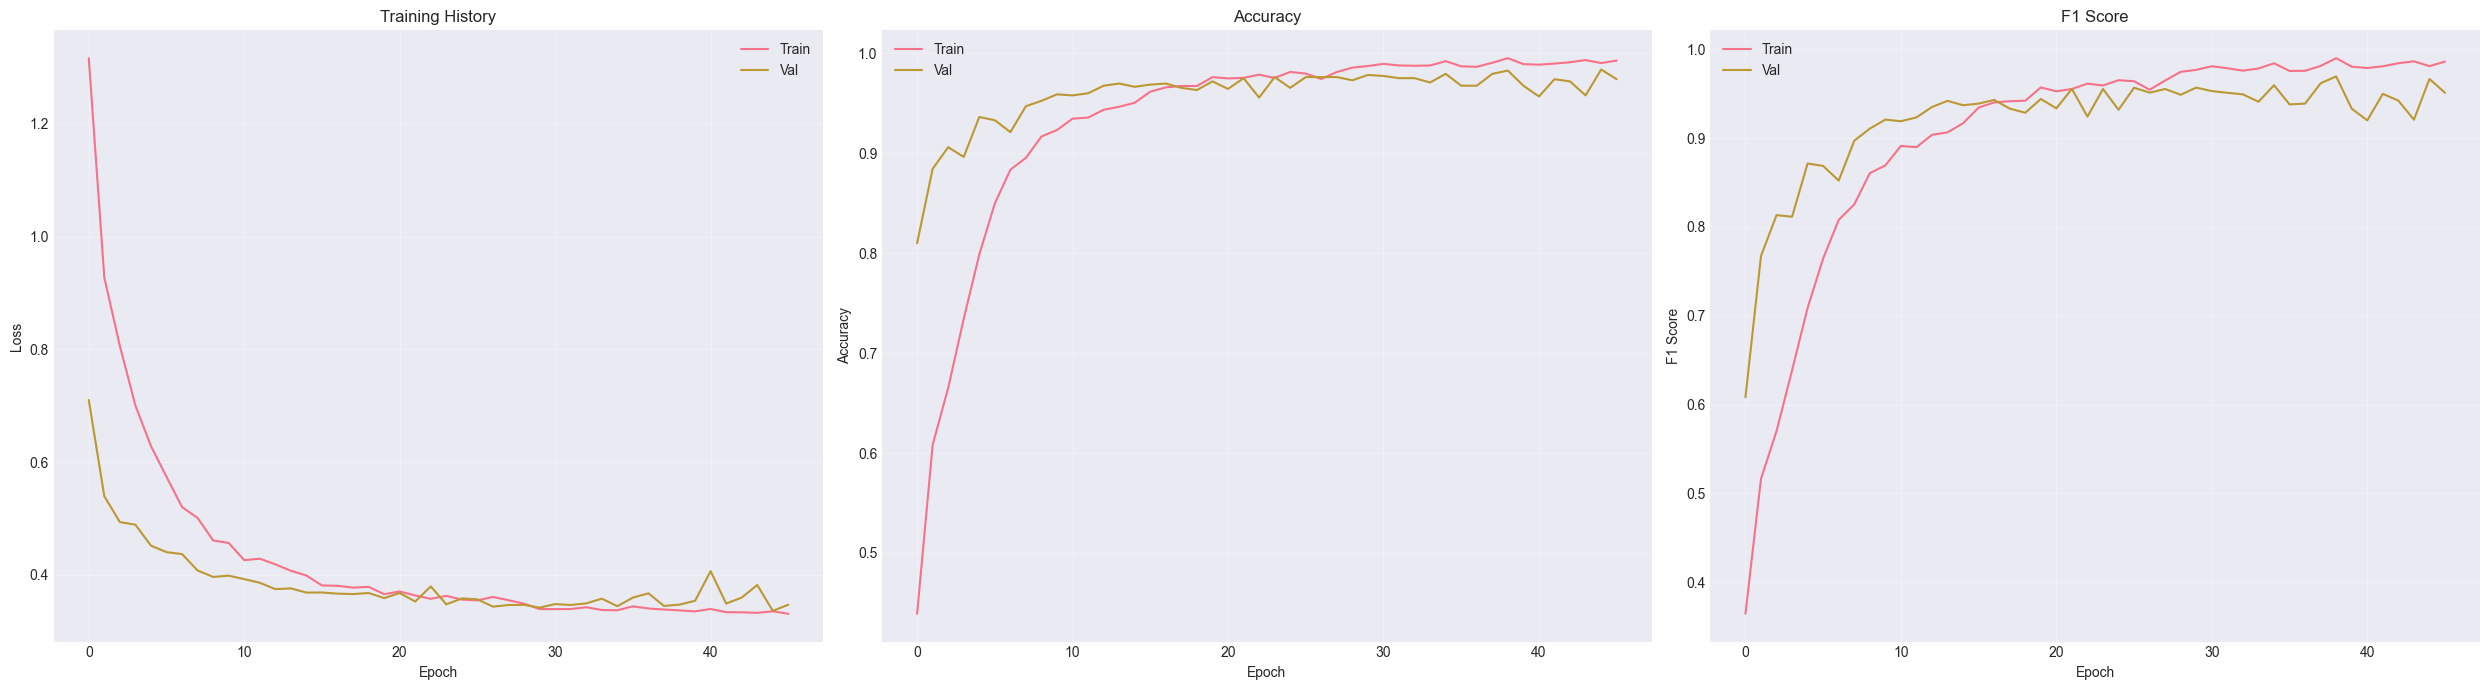

In [ ]:
# Plot history
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(25, 7))

ax1.plot(history.history['loss'], label='Train')
ax1.plot(history.history['val_loss'], label='Val')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Training History')
ax1.legend()
ax1.grid(True, alpha=0.3)

ax2.plot(history.history['accuracy'], label='Train')
ax2.plot(history.history['val_accuracy'], label='Val')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.set_title('Accuracy')
ax2.legend()
ax2.grid(True, alpha=0.3)

ax3.plot(history.history['macro_f1'], label='Train')
ax3.plot(history.history['val_macro_f1'], label='Val')
ax3.set_xlabel('Epoch')
ax3.set_ylabel('F1 Score')
ax3.set_title('F1 Score')
ax3.legend()
ax3.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 8. Evaluation

29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step
📊 Classification Report:

              precision    recall  f1-score   support

   high_pain     0.9167    0.9872    0.9506        78
    low_pain     0.9769    0.9621    0.9695       132
     no_pain     0.9916    0.9860    0.9888       716

    accuracy                         0.9827       926
   macro avg     0.9617    0.9784    0.9696       926
weighted avg     0.9832    0.9827    0.9828       926


🎯 F1 Score (macro): 0.9696


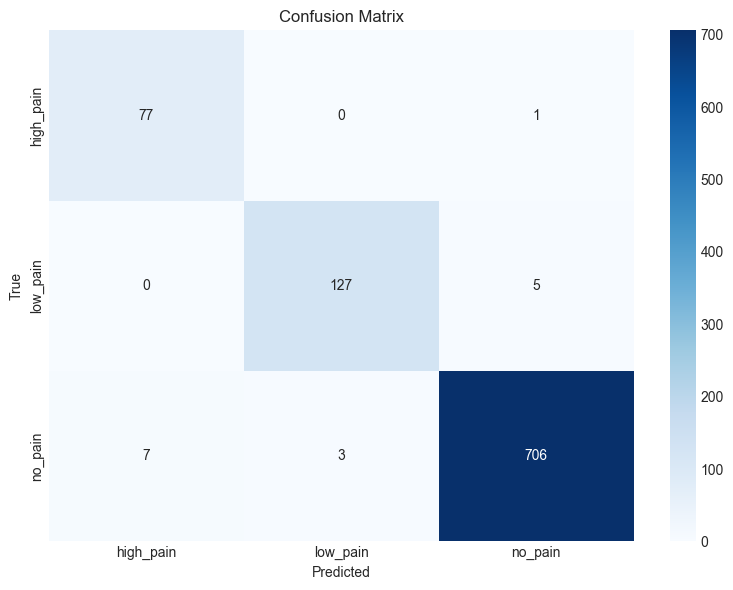

In [ ]:
# Evaluate
y_pred_prob = model.predict(X_val)
y_pred = np.argmax(y_pred_prob, axis=1)

print('📊 Classification Report:\n')
print(classification_report(y_val, y_pred, target_names=label_encoder.classes_, digits=4))

# F1 Score
f1_macro = f1_score(y_val, y_pred, average='macro')
print(f'\n🎯 F1 Score (macro): {f1_macro:.4f}')

# Confusion matrix
cm = confusion_matrix(y_val, y_pred)
fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_, ax=ax)
ax.set_xlabel('Predicted')
ax.set_ylabel('True')
ax.set_title('Confusion Matrix')
plt.tight_layout()
plt.show()

## 🎓 Summary

Pipeline completa e funzionante con tutte le ADVICE integrate:

1. **ADVICE 11/11**: Window size da autocorrelazione
2. **ADVICE 12/11**: Time features ciclici
3. **ADVICE 13/11**: Conv1D + LSTM
4. **ADVICE 10/11**: Gradient clipping (clipnorm=1.0)
5. **ADVICE 09/11**: Label smoothing (0.1)
6. **ADVICE 08/11**: Class weighting (balanced)
7. **ADVICE 07/11**: Categorical mapping

**Dataset**: 661 samples × 160 timesteps × 38 features  
**Classes**: no_pain, low_pain, high_pain (sbilanciato)

✅ **Pronto per essere eseguito end-to-end!** 🏴‍☠️

## 9. Test Set Prediction e Submission

In [ ]:
# Load test data
X_test = pd.read_csv('pirate_pain_test.csv')

print(f'📊 Test Data:')
print(f'   Shape: {X_test.shape}')
print(f'   Samples: {X_test["sample_index"].nunique()}')
print(f'   Timesteps/sample: {X_test.groupby("sample_index").size().iloc[0]}')

📊 Test Data:
   Shape: (211840, 40)
   Samples: 1324
   Timesteps/sample: 160


In [ ]:
# Apply same preprocessing to test
X_test_proc = X_test.copy()

# ADVICE 07/11: Map categorical
for col, mapping in cat_map.items():
    X_test_proc[col] = X_test_proc[col].map(mapping).fillna(0).astype(int)

# ADVICE 12/11: Add time features
max_time_test = X_test_proc['time'].max()
X_test_proc['time_sin'] = np.sin(2*np.pi*X_test_proc['time']/max_time_test)
X_test_proc['time_cos'] = np.cos(2*np.pi*X_test_proc['time']/max_time_test)
X_test_proc['time_norm'] = X_test_proc['time']/max_time_test

print('✅ Test preprocessing done')

✅ Test preprocessing done


In [ ]:
# Create windows for test and predict
print('🔄 Creating test windows and predicting...')

test_sample_indices = X_test['sample_index'].unique()
sample_predictions = {}  # Store predictions per sample

for sid in tqdm(test_sample_indices, desc='Predicting'):
    # Create windows for this sample
    windows = create_windows(X_test_proc, sid, WINDOW_SIZE, WINDOW_STRIDE)
    
    if len(windows) > 0:
        # Convert to array and normalize
        X_sample = np.array(windows, dtype=np.float32)
        X_sample = scaler.transform(
            X_sample.reshape(-1, X_sample.shape[-1])
        ).reshape(X_sample.shape)
        
        # Predict probabilities for all windows
        probs = model.predict(X_sample, verbose=0)
        
        # Aggregate: average probabilities across windows, then argmax
        avg_probs = probs.mean(axis=0)
        pred_class = np.argmax(avg_probs)
        
        sample_predictions[sid] = pred_class

print(f'✅ Predicted {len(sample_predictions)} samples')

🔄 Creating test windows and predicting...


Predicting: 100%|██████████| 1324/1324 [00:39<00:00, 33.59it/s]

✅ Predicted 1324 samples


In [ ]:
# Create submission DataFrame
submission_data = []
for sid in sorted(sample_predictions.keys()):
    pred_class = sample_predictions[sid]
    pred_label = label_encoder.classes_[pred_class]
    submission_data.append({
        'sample_index': sid,
        'label': pred_label
    })

submission = pd.DataFrame(submission_data)

# Save submission
submission.to_csv('submission.csv', index=False)

print('✅ Submission created!')
print(f'   Shape: {submission.shape}')
print(f'   Columns: {list(submission.columns)}')
print(f'\n📊 Predicted label distribution:')
print(submission['label'].value_counts())
print(f'\n💾 Saved to: submission.csv')
display(submission.head(10))

✅ Submission created!
   Shape: (1324, 2)
   Columns: ['sample_index', 'label']

📊 Predicted label distribution:
label
no_pain      988
low_pain     182
high_pain    154
Name: count, dtype: int64

💾 Saved to: submission.csv


,sample_index,label
0,0,no_pain
1,1,no_pain
2,2,no_pain
3,3,no_pain
4,4,no_pain
5,5,no_pain
6,6,high_pain
7,7,no_pain
8,8,no_pain
9,9,no_pain


## 10. F1 Score Analysis e Ottimizzazione

Analizziamo come massimizzare l'F1 macro score sulla validation per migliorare le performance sul test.

🎯 F1 Score Analysis on Validation Set

29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
📊 Per-Class Metrics:

high_pain:
  Precision: 0.9167
  Recall:    0.9872
  F1 Score:  0.9506

low_pain:
  Precision: 0.9769
  Recall:    0.9621
  F1 Score:  0.9695

no_pain:
  Precision: 0.9916
  Recall:    0.9860
  F1 Score:  0.9888

🎯 Overall F1 Scores:
   F1 Macro (challenge metric):    0.9696
   F1 Weighted:                     0.9828


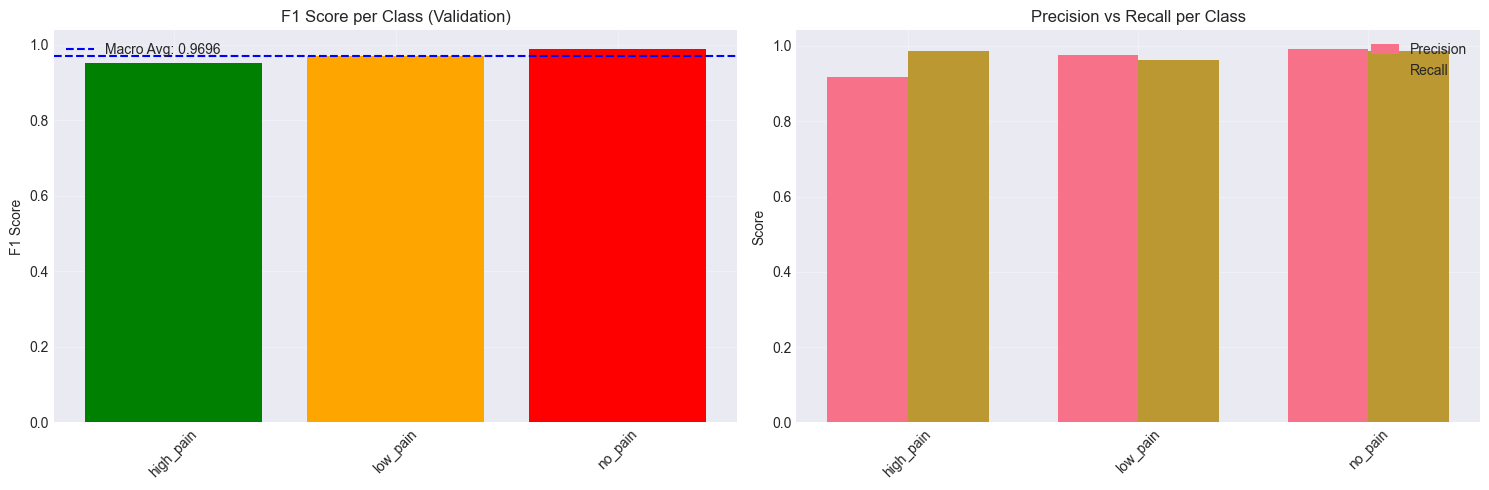

In [ ]:
# Analyze F1 score per class
from sklearn.metrics import f1_score, precision_score, recall_score

print('🎯 F1 Score Analysis on Validation Set\n')

# Get predictions
y_pred_prob = model.predict(X_val)
y_pred = np.argmax(y_pred_prob, axis=1)

# Calculate per-class metrics
f1_per_class = f1_score(y_val, y_pred, average=None)
precision_per_class = precision_score(y_val, y_pred, average=None)
recall_per_class = recall_score(y_val, y_pred, average=None)

print('📊 Per-Class Metrics:\n')
for i, label_name in enumerate(label_encoder.classes_):
    print(f'{label_name}:')
    print(f'  Precision: {precision_per_class[i]:.4f}')
    print(f'  Recall:    {recall_per_class[i]:.4f}')
    print(f'  F1 Score:  {f1_per_class[i]:.4f}')
    print()

# Overall F1 scores
f1_macro = f1_score(y_val, y_pred, average='macro')
f1_weighted = f1_score(y_val, y_pred, average='weighted')

print(f'🎯 Overall F1 Scores:')
print(f'   F1 Macro (challenge metric):    {f1_macro:.4f}')
print(f'   F1 Weighted:                     {f1_weighted:.4f}')

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Per-class F1 scores
ax1 = axes[0]
x_pos = np.arange(len(label_encoder.classes_))
ax1.bar(x_pos, f1_per_class, color=['green', 'orange', 'red'])
ax1.set_xticks(x_pos)
ax1.set_xticklabels(label_encoder.classes_, rotation=45)
ax1.set_ylabel('F1 Score')
ax1.set_title('F1 Score per Class (Validation)')
ax1.axhline(y=f1_macro, color='blue', linestyle='--', label=f'Macro Avg: {f1_macro:.4f}')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Precision-Recall per class
ax2 = axes[1]
x_pos = np.arange(len(label_encoder.classes_))
width = 0.35
ax2.bar(x_pos - width/2, precision_per_class, width, label='Precision')
ax2.bar(x_pos + width/2, recall_per_class, width, label='Recall')
ax2.set_xticks(x_pos)
ax2.set_xticklabels(label_encoder.classes_, rotation=45)
ax2.set_ylabel('Score')
ax2.set_title('Precision vs Recall per Class')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 💡 Tips per Massimizzare F1 Macro Score

### 1. Class Weighting (già applicato ✅)
Il class weighting aiuta con lo sbilanciamento, ma potrebbe non essere sufficiente.

### 2. Threshold Tuning
Invece di usare argmax, prova threshold diversi per ogni classe:
```python
# Esempio: bias verso classi minoritarie
thresholds = [0.3, 0.4, 0.5]  # per no_pain, low_pain, high_pain
```

### 3. Ensemble di Predizioni
Invece di media semplice sulle finestre, prova:
- Media pesata (finestre centrali contano di più)
- Voting (maggioranza tra finestre)
- Max pooling delle probabilità

### 4. Data Augmentation
Per le classi minoritarie:
- Noise injection
- Time warping
- Window shift augmentation

### 5. Focal Loss
Invece di label smoothing, usa focal loss per dare più peso agli esempi difficili:
```python
# Focal loss = CE * (1-p)^gamma
# Mette più enfasi su campioni classificati male
```

### 6. Class-specific Hyperparameters
Allena modelli separati o usa attention mechanism per dare più capacità alle classi minoritarie.

### 7. Cross-Validation
Usa K-fold CV per avere stime più robuste dell'F1:
```python
from sklearn.model_selection import StratifiedKFold
# 5-fold CV per vedere stabilità F1
```

### 🎯 Focus sulle Classi Minoritarie
F1 macro = media delle F1 per classe, quindi:
- **low_pain** e **high_pain** hanno peso uguale a **no_pain**
- Migliora recall su classi minoritarie
- Monitora confusion matrix per vedere dove sbaglia

### ⚠️ Overfitting Warning
Se F1 validation >> F1 test:
- Aumenta regolarizzazione (dropout, weight decay)
- Riduci model complexity
- Usa early stopping più aggressivo
